In [281]:
import pandas as pd
import numpy as np

# Import Regular Expression
import re

# Loading the data
df = pd.read_csv("Data/jumia_phones.csv")

# Display the first few rows of the data to get a sense of the data structure
df.head()

,Name,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,"XIAOMI Redmi A3, 6.71"", 3GB RAM + 64GB (Dual S...","KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,"Tecno Spark 20, Android 13, 6.6"", 128GB + 4GB ...","KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,"Samsung Galaxy A05, 6.7'' 4GB RAM + 128GB ROM ...","KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


***

## Data Cleaning

Let us define a function to extract the different phone features from the name column

In [283]:
# Column name to work with
product_column = 'Name'

# Function to extract a feature based on regex and rename the column
def extract_feature(df, column, pattern, feature_name):
    def extractor(name):
        match = re.search(pattern, name)
        return match.group(1).strip() if match else None

    return df[column].apply(extractor).rename(feature_name)

# Define regex patterns
patterns = {
    'Brand': r"(?P<brand>[\w\s]+)(?=\+|,\s|\s|$)",
    'Screen Size': r"(?P<screen_size>\d+(\.\d+)?)(?=['\"]{1,2})",
    'RAM': r"\b(?P<RAM>\d\s?GB)\b",
    'ROM': r"\b(?P<ROM>\d{2,}\s?GB)\b",
    'Color': r"[,-]\s*(?P<Color>([A-Z][a-z]+(?:\s[A-Z][a-z]+)*))\s*(?:\+.*)?(?=\s*\(|$)",
    'Warranty': r"(\d+)\s*(?:YR|WRTY)",
    'Camera': r'(\d+MP)',
    'Battery': r'(\d{4}mAh)',
    'Number of SIMs': r'\(?(Dual\s+Sim|DUAL\s+SIM|Single\s+Sim|Single)\)?'
}

# Extract features using the defined patterns
extracted_features = {
    name: extract_feature(df, product_column, pattern, name)
    for name, pattern in patterns.items()
}

# Special handling for Warranty and Number of SIMs
extracted_features['Warranty'] = extracted_features['Warranty'].apply(lambda x: 2 if x == '2' else (1 if x == '1' else 0))
extracted_features['sim_cards'] = extracted_features['Number of SIMs'].apply(lambda x: 2 if x and 'Dual' in x else 1)

# Clean up the Brand column to title case
extracted_features['Brand'] = extracted_features['Brand'].str.lower().str.title()

# Combine all extracted features into a single DataFrame
extracted_features_df = pd.DataFrame(extracted_features)

# Concatenate with the original DataFrame, excluding the product column
final_df = pd.concat([extracted_features_df, df.drop(columns=[product_column])], axis=1)

# Display the final DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [284]:
# Let us clean the Rating column to keep only the result and rename it to Ratings_out_of_5
final_df['Ratings'] = final_df['Rating'].str.extract(r'(\d+\.\d+)')[0]

# Drop the Rating column
final_df.drop(columns=['Rating'], inplace=True)

# Clean the Number of Reviews column to extract the number in parentheses
final_df['Reviews'] = final_df['Number of Reviews'].str.extract(r'\((\d+)\)')[0]

# Drop the Number of reviews column from the Dataset
final_df.drop(columns=['Number of Reviews'], inplace=True)

# Define regex pattern to extract page and rank
pattern = r'Page (?P<Page>\d+), Rank (?P<Rank>\d+)'

# Extract page and rank into new columns
final_df[['Page', 'Rank']] = final_df['Search Ranking'].str.extract(pattern)

# Display the cleaned DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Search Ranking,Ratings,Reviews,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,"Page 1, Rank 1",4.1,220,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,"Page 1, Rank 2",4.4,135,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 3",4.2,151,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,"Page 1, Rank 4",4.5,29,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 5",4.3,249,1,5


Let us see which phones are with missing values in the camera column and try to get the camera specs from the internet and impute it in the dataset.

In [285]:
# Filter rows where Camera is NaN
phones_with_nan_camera = final_df[final_df['Camera'].isna()]

# Count the number of unique brands with NaN Camera
phones_with_nan_camera['Brand'].value_counts()

Brand
Xiaomi Redmi 14C       900
Xiaomi Redmi A3        600
Infinix Smart 8        600
Samsung Galaxy A05S    300
Oppo A83 4Gb Ram       300
Oppo A17K              300
Itel A18               300
Name: count, dtype: int64

Let us check the internet and see what the camera specs for these devices are since the list is small. We will ipute these details in the missing values for camera and keep the entries rather than dropping them.

In [286]:
# Dictionary with phone models and their corresponding rear camera megapixels (numeric only) aquired from the internet
camera_specs = {
    "Xiaomi Redmi 14C": 50,  # 50 MP camera
    "Xiaomi Redmi A3": 13,   # 13 MP camera
    "Infinix Smart 8": 13,   # 13 MP camera
    "Samsung Galaxy A05S": 50,  # 50 MP camera
    "Oppo A83 4Gb Ram": 13,   # 13 MP camera
    "Oppo A17K": 50,          # 50 MP camera
    "Itel A18": 5            # 5 MP camera
}

# Function to replace NaN values with the camera specs from the dictionary (numeric only)
def replace_camera_specs(row):
    if pd.isna(row['Camera']) and row['Brand'] in camera_specs:
        return camera_specs[row['Brand']]
    return row['Camera']

# Apply the function to the 'Camera' column
final_df['Camera'] = final_df.apply(replace_camera_specs, axis=1)

# Print the updated DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Search Ranking,Ratings,Reviews,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,13,5000mAh,None,1,"KSh 11,000",NaN,NaN,"Page 1, Rank 1",4.1,220,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,"Page 1, Rank 2",4.4,135,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 3",4.2,151,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,"Page 1, Rank 4",4.5,29,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,"Page 1, Rank 5",4.3,249,1,5


In [287]:
# Rename Brand to phone_name, Screen Size to display, ROM to storage
final_df.rename(columns={'Brand': 'phone_name', 'Screen Size': 'display', 'ROM': 'storage'}, inplace=True)

# Drop the Search Ranking and Old Price column
final_df.drop(columns=['Search Ranking', 'Old Price', 'Number of SIMs'], inplace=True)

# Change all column names to lowercase and add _ between the parts of the column names
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')

# Display the cleaned DataFrame
final_df['color'].head(100)

# Get the 97th entry in the final_df
final_df.iloc[97]

phone_name     Itel S23
display             6.6
ram                 8GB
storage           128GB
color              None
warranty              0
camera             50MP
battery         5000mAh
sim_cards             1
price         KSh 9,999
discount            50%
ratings             4.5
reviews              41
page                  3
rank                 18
Name: 97, dtype: object

In [288]:
# Let us check our modified DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   phone_name  12000 non-null  object
 1   display     11100 non-null  object
 2   ram         12000 non-null  object
 3   storage     12000 non-null  object
 4   color       9600 non-null   object
 5   warranty    12000 non-null  int64 
 6   camera      12000 non-null  object
 7   battery     9300 non-null   object
 8   sim_cards   12000 non-null  int64 
 9   price       12000 non-null  object
 10  discount    8101 non-null   object
 11  ratings     10200 non-null  object
 12  reviews     11700 non-null  object
 13  page        12000 non-null  object
 14  rank        12000 non-null  object
dtypes: int64(2), object(13)
memory usage: 1.4+ MB


In [289]:
# Check for missing values in the dataframe
final_df.isnull().sum()

phone_name       0
display        900
ram              0
storage          0
color         2400
warranty         0
camera           0
battery       2700
sim_cards        0
price            0
discount      3899
ratings       1800
reviews        300
page             0
rank             0
dtype: int64

In [290]:
# Convert Screen Size to float
final_df['display'] = final_df['display'].astype(float)
final_df['ratings'] = final_df['ratings'].astype(float)

# Convert RAM and ROM to integer
final_df['ram'] = final_df['ram'].str.replace('GB', '').astype(int)
final_df['storage'] = final_df['storage'].str.replace('GB', '').astype(int)

# Convert Page and Rank to integer
final_df['page'] = final_df['page'].astype(int)
final_df['rank'] = final_df['rank'].astype(int)

# Convert Price and Old Price to float
final_df['price'] = final_df['price'].str.replace(r'[^\d]', '', regex=True).astype(float)

# Convert the Reviews to numbers
final_df['reviews'] = final_df['reviews'].fillna(0).astype(float).astype(int)

#View the first 6 rows of the final set
final_df.head()

,phone_name,display,ram,storage,color,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,Midnight Black,2,13,5000mAh,1,11000.0,NaN,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,Gravity Black,1,50MP,5000mAh,1,12925.0,14%,4.4,135,1,2
2,Itel S23,6.60,4,128,Mystery White,1,50MP,5000mAh,1,10000.0,NaN,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,Black,0,50MP,5000mAh,2,14000.0,NaN,4.5,29,1,4
4,Itel S23,6.60,4,128,Starry Black,0,50MP,5000mAh,1,10000.0,NaN,4.3,249,1,5


In [291]:
# Drop the color column
final_df.drop(columns=['color'], inplace=True)

# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from battery entries and handle None values
final_df['battery'] = final_df['battery'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# Remove the % symbol from the discount entries
final_df['discount'] = final_df['discount'].str.replace('%', '')

final_df.head()

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,NaN,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,1,50MP,5000,1,12925.0,14,4.4,135,1,2
2,Itel S23,6.60,4,128,1,50MP,5000,1,10000.0,NaN,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50MP,5000,2,14000.0,NaN,4.5,29,1,4
4,Itel S23,6.60,4,128,0,50MP,5000,1,10000.0,NaN,4.3,249,1,5


In [292]:
# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from camera entries
final_df['camera'] = final_df['camera'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# View the first 10 rows of the final DataFrame to check for any changes in the data structure and values
final_df.head(10)

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,ratings,reviews,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,0,4.1,220,1,1
1,Tecno Spark 20,6.60,4,128,1,50,5000,1,12925.0,14,4.4,135,1,2
2,Itel S23,6.60,4,128,1,50,5000,1,10000.0,0,4.2,151,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,14000.0,0,4.5,29,1,4
4,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,4.3,249,1,5
5,Samsung Galaxy A15,6.50,4,128,0,50,5000,1,17445.0,42,4.2,420,1,6
6,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,13899.0,40,3.9,116,1,7
7,Xiaomi Redmi 13C,6.74,8,256,0,50,5000,2,16899.0,44,NaN,151,1,8
8,Tecno Spark 20,6.60,8,128,0,50,None,2,14399.0,45,4.1,198,1,9
9,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,4.2,111,1,10


In [293]:
# Get the mode (most frequent value) from the 'battery' column
battery_mode = final_df['battery'].mode()[0]

# Fill missing values in 'Battery' column with the mode value
final_df['battery'] = final_df['battery'].fillna(battery_mode)

# Check the DataFrame info to see if the missing values were filled
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  12000 non-null  object 
 1   display     11100 non-null  float64
 2   ram         12000 non-null  int64  
 3   storage     12000 non-null  int64  
 4   warranty    12000 non-null  int64  
 5   camera      12000 non-null  object 
 6   battery     12000 non-null  object 
 7   sim_cards   12000 non-null  int64  
 8   price       12000 non-null  float64
 9   discount    12000 non-null  object 
 10  ratings     10200 non-null  float64
 11  reviews     12000 non-null  int64  
 12  page        12000 non-null  int64  
 13  rank        12000 non-null  int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.3+ MB


In [294]:
# Let us drop the None values from the dataframe
final_df = final_df.dropna()

# Display the final DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   object 
 6   battery     9600 non-null   object 
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   object 
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.1+ MB


In [295]:
# let us convert the battery, camera, and discount entries to integer
final_df['battery'] = final_df['battery'].astype(int)
final_df['camera'] = final_df['camera'].astype(int)
final_df['discount'] = final_df['discount'].astype(int)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   int64  
 6   battery     9600 non-null   int64  
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   int64  
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB


***

## Exploratory Data Analysis (EDA) for the price feature
Performing a comprehensive EDA on the price feature will help us understand its distribution, relationships with other variables, and potential outliers. Here is step by step process we will follow for a thorough EDA of the price feature using pandas, matplotlib, and seaborn.

1. **Importing Libraries:**
First, we need to import the necessary libraries.

2. **Basic Information and Descriptive Statistics:**
We will start by understanding the basic statistics and characteristics of the price feature.

3. **Distribution of price:**
Next, we will plot the distribution of the price feature using both a histogram and a kernel density estimate (KDE) plot to understand its spread and shape.

4. **Boxplot to Detect Outliers:**
A boxplot is a good way to visually identify potential outliers in the price feature.

5. **Price Correlation with Other Features:**
To understand how price relates to other numerical features, we can compute the correlation matrix and visualize it with a heatmap.
This will show us the correlation values between price and other numerical features. Positive correlations suggest that as one feature increases, so does the price, and vice versa.

6. **Price vs Other Features (Scatter Plots):**
You may want to visualize how price relates to each of the top correlated features (e.g., storage, camera, battery, etc.).

7. **Price vs Categorical Features:**
You may also want to investigate how categorical features (e.g., brand, warranty, sim_cards) relate to the price. This can be done using boxplots or violin plots.

8. **Outliers Detection:**
If you want to perform a more statistical approach to detect outliers in the price feature, you can use the Z-score or IQR (Interquartile Range) method.
**Z-score Method:** Identifying outliers where the absolute Z-score is greater than 3.
**IQR Method:** Identifying outliers using the IQR range.

9. **Skewness and Kurtosis:**
Finally, you may want to assess the distribution of the price using skewness and kurtosis to understand if it's normally distributed.
**Skewness:** If skewness is positive, the distribution is right-skewed (long tail on the right); if negative, the distribution is left-skewed.
**Kurtosis:** Positive kurtosis indicates a distribution with heavy tails or outliers, while negative kurtosis indicates a light-tailed distribution.

After this EDA, we will have a better understanding of the price feature and its relationship with other features. Depending on our findings, we may choose to handle outliers, transform the data (e.g., log-transformation for skewed data), or further explore relationships with categorical variables.

In [300]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display basic information about the data
print("Basic Info about the Dataset")
print(final_df.info())

# Display summary statistics for 'price' feature
print("\nDescriptive Statistics for 'price' feature")
print(final_df['price'].describe())

Basic Info about the Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phone_name  9600 non-null   object 
 1   display     9600 non-null   float64
 2   ram         9600 non-null   int64  
 3   storage     9600 non-null   int64  
 4   warranty    9600 non-null   int64  
 5   camera      9600 non-null   int64  
 6   battery     9600 non-null   int64  
 7   sim_cards   9600 non-null   int64  
 8   price       9600 non-null   float64
 9   discount    9600 non-null   int64  
 10  ratings     9600 non-null   float64
 11  reviews     9600 non-null   int64  
 12  page        9600 non-null   int64  
 13  rank        9600 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB
None

Descriptive Statistics for 'price' feature
count     9600.000000
mean     14123.635313
std       4306.461803
min       7000.000000
25%      108

***Dataset Overview***
The dataset consists of 9,600 mobile phone entries with 14 features, including details like display size, RAM, storage, warranty, camera, battery, and price. The data is represented in a Pandas DataFrame, and all columns contain non-null values.
The price values range from 7,000 to 24,999, with most phones priced between 10,863 and 15,437.

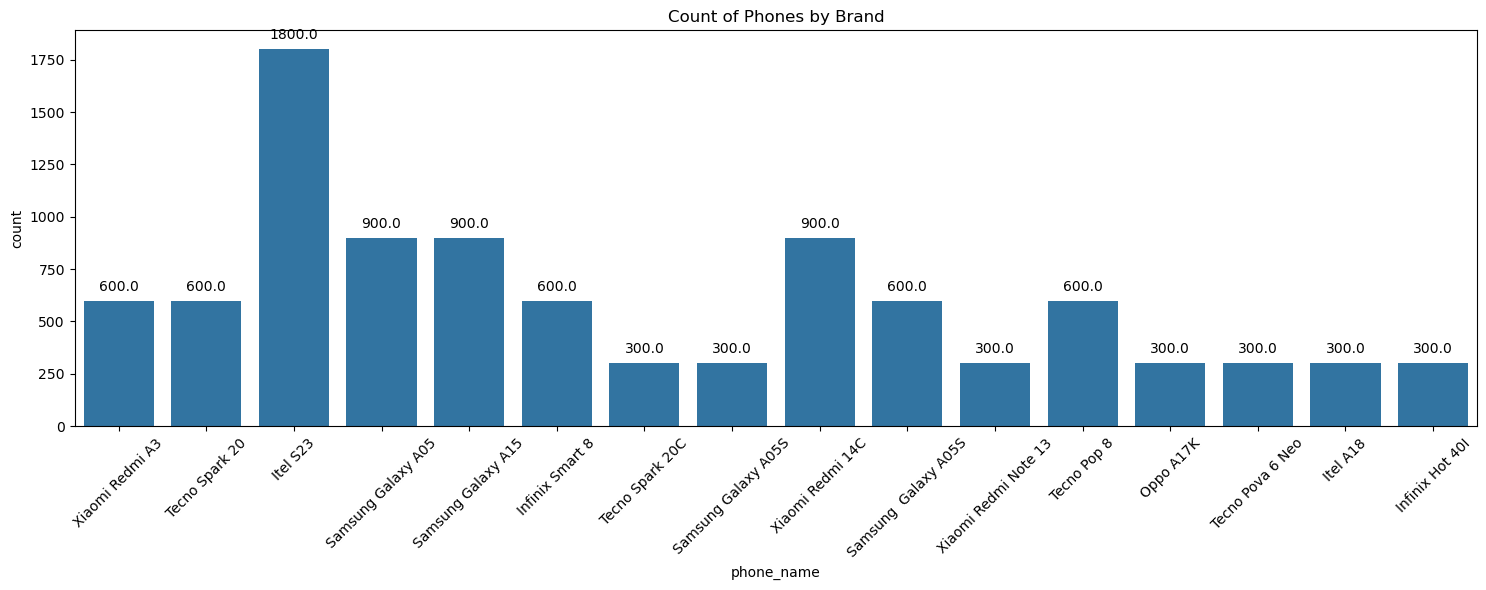

In [301]:
# Plotting a count plot of phone brands in final_df with annotations and rotated labels for better readability
# Set figure size for the plot
plt.figure(figsize=(15, 6))
# Count plot for 'Brand' column in the dataset
ax1 = sns.countplot(x='phone_name', data=final_df)
plt.title('Count of Phones by Brand')
# Annotate each bar with its corresponding count value
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Automatically adjust layout to prevent clipping
plt.tight_layout()
plt.show()

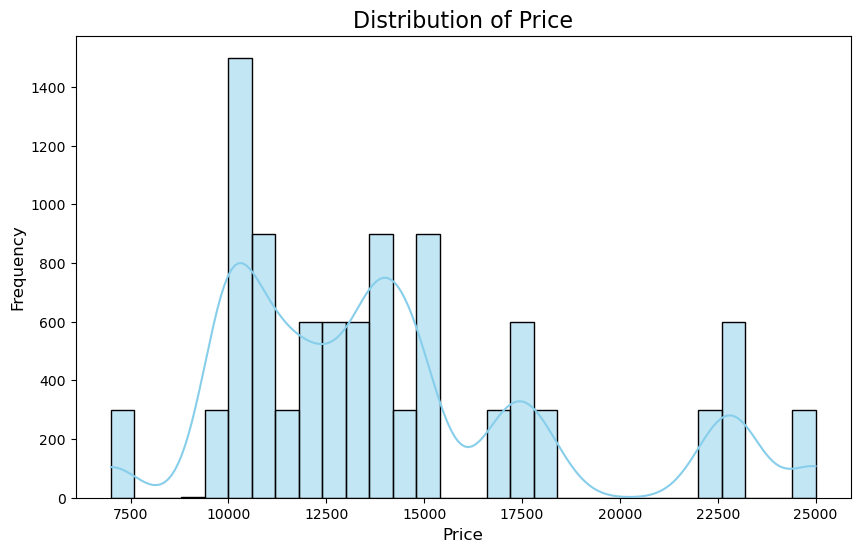

In [302]:
# Plot the distribution of 'price'
plt.figure(figsize=(10, 6))

# Histogram with KDE overlay
sns.histplot(final_df['price'], kde=True, bins=30, color='skyblue')

plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

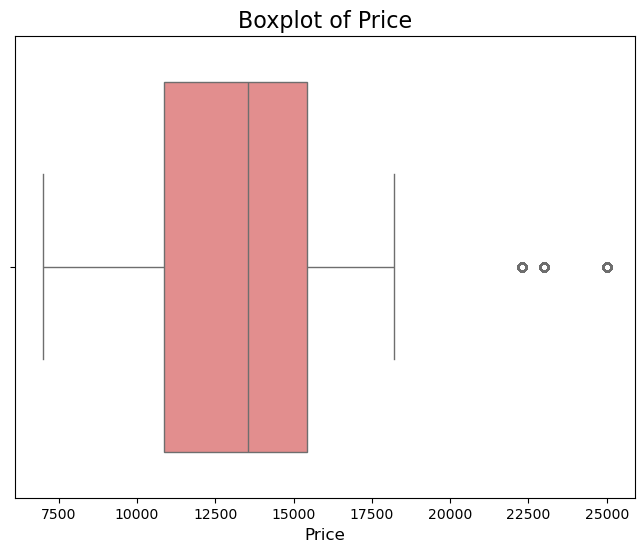

In [303]:
# Boxplot to detect outliers
plt.figure(figsize=(8, 6))

sns.boxplot(x=final_df['price'], color='lightcoral')

plt.title('Boxplot of Price', fontsize=16)
plt.xlabel('Price', fontsize=12)

plt.show()

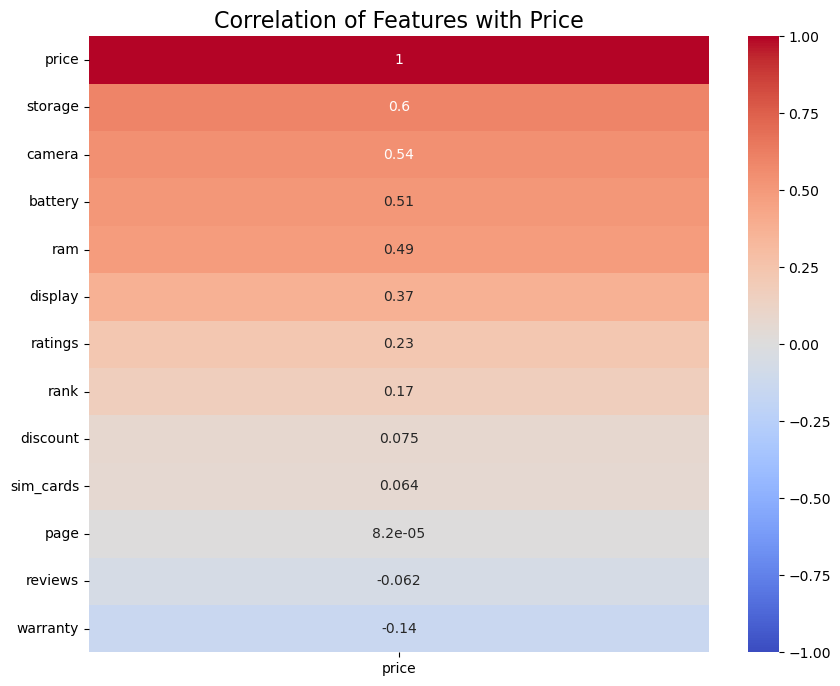

In [304]:
# Plotting a heatmap of correlations
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation of Features with Price', fontsize=16)
plt.show()

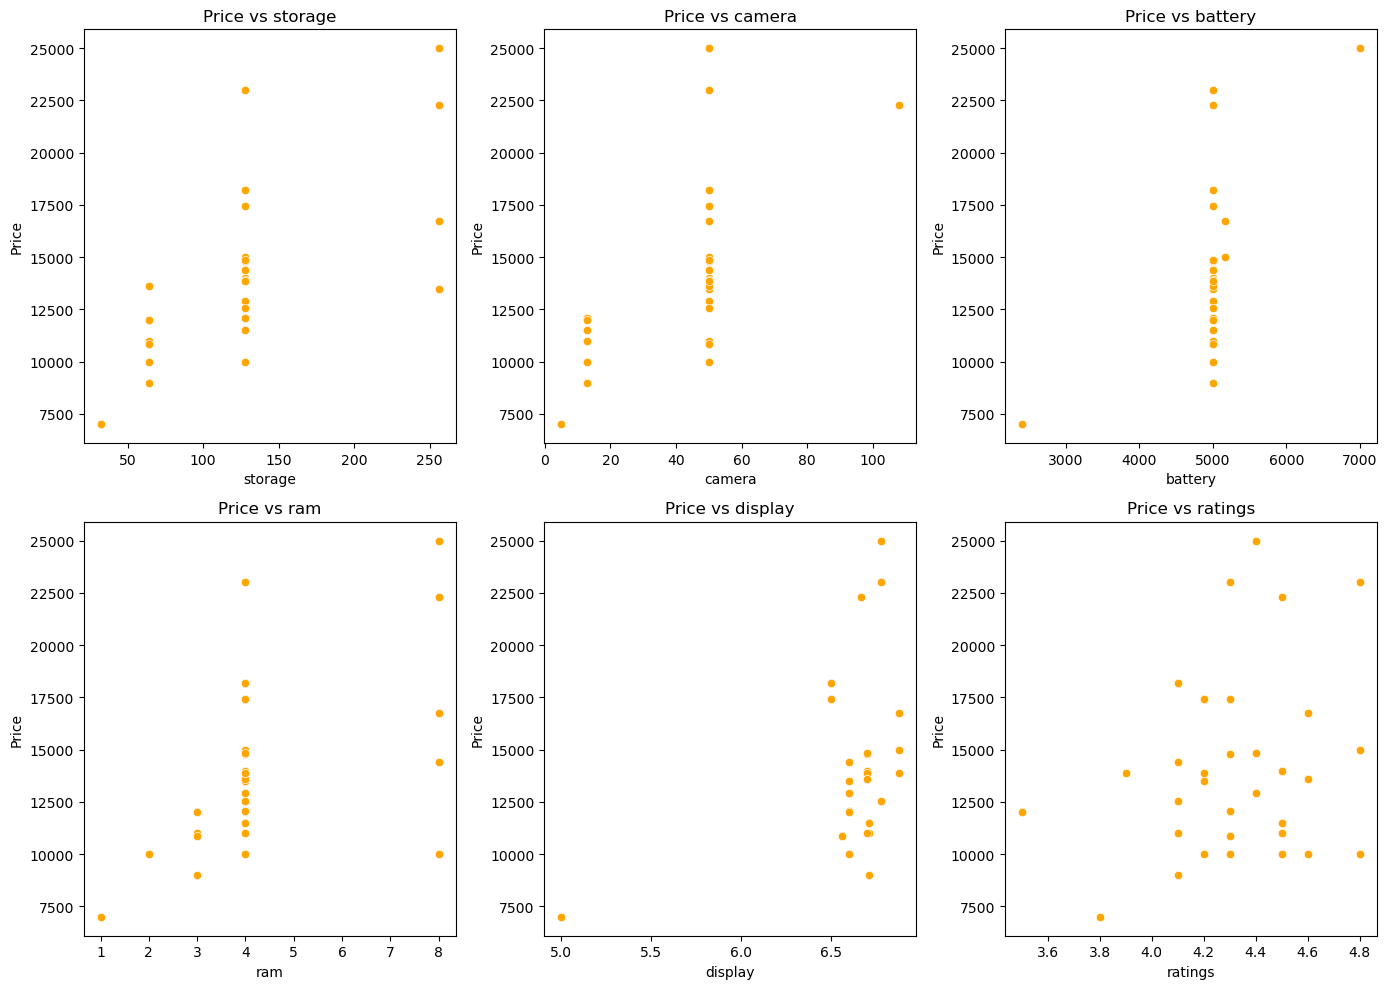

In [305]:
# List of top features that are correlated with 'price'
top_features = ['storage', 'camera', 'battery', 'ram', 'display', 'ratings']

# Create scatter plots for price vs these features
plt.figure(figsize=(14, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=numerical_df, x=feature, y='price', color='orange')
    plt.title(f'Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_1200/1790784352.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='phone_name', y='price', data=final_df, palette='Set2')


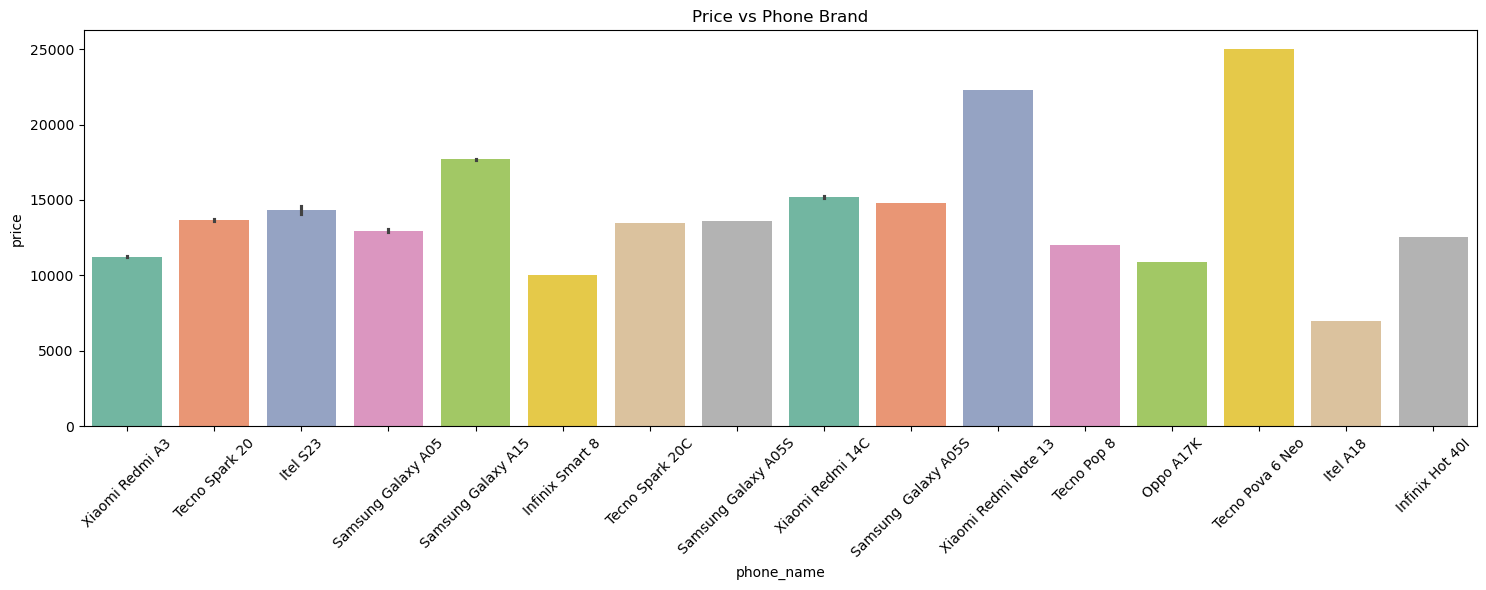

In [307]:
# Set figure size for the plot
plt.figure(figsize=(15, 6))

# Boxplot for 'phone_name' (or any other categorical feature) vs 'price'
sns.barplot(x='phone_name', y='price', data=final_df, palette='Set2')

# Title of the plot
plt.title('Price vs Phone Brand')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Automatically adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

In [310]:
# Z-score method for outlier detection
z_scores = np.abs(stats.zscore(final_df['price']))

# Find outliers
outliers_zscore = final_df[z_scores > 3]

print(f"Outliers detected using Z-score method: {outliers_zscore}")

Outliers detected using Z-score method: Empty DataFrame
Columns: [phone_name, display, ram, storage, warranty, camera, battery, sim_cards, price, discount, ratings, reviews, page, rank]
Index: []


In [312]:
# IQR Method for detecting outliers
Q1 = final_df['price'].quantile(0.25)
Q3 = final_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = final_df[(final_df['price'] < (Q1 - 1.5 * IQR)) | (final_df['price'] > (Q3 + 1.5 * IQR))]

print(f"Outliers detected using IQR method: {outliers_iqr}")

Outliers detected using IQR method:                  phone_name  display  ram  storage  warranty  camera  battery  \
15                 Itel S23     6.78    4      128         0      50     5000   
18     Xiaomi Redmi Note 13     6.67    8      256         0     108     5000   
30         Tecno Pova 6 Neo     6.78    8      256         0      50     7000   
38                 Itel S23     6.78    4      128         0      50     5000   
55                 Itel S23     6.78    4      128         0      50     5000   
...                     ...      ...  ...      ...       ...     ...      ...   
11958              Itel S23     6.78    4      128         0      50     5000   
11975              Itel S23     6.78    4      128         0      50     5000   
11978  Xiaomi Redmi Note 13     6.67    8      256         0     108     5000   
11990      Tecno Pova 6 Neo     6.78    8      256         0      50     7000   
11998              Itel S23     6.78    4      128         0      50     


**Outliers Detected Using the IQR Method**
The IQR (Interquartile Range) method was used to identify outliers in the price column of the dataset. The outliers are phone entries with prices either below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

A total of 1,200 rows (phones) were identified as outliers based on their price values.
These phones generally have prices above 23,000 or below 7,000, which are considered extreme compared to the interquartile range of the price distribution.
This indicates that these particular phones may have unusually high or low prices compared to most of the other entries in the dataset.

We will take note of these outliers, however we will not remove them from the dataset yet.

In [313]:
# Calculate skewness and kurtosis
skewness = final_df['price'].skew()
kurtosis = final_df['price'].kurt()

print(f"Skewness of price: {skewness}")
print(f"Kurtosis of price: {kurtosis}")

Skewness of price: 0.9673614527445935
Kurtosis of price: 0.28612489421567666


**Skewness and Kurtosis of Price**

**Skewness:** The skewness of the price distribution is 0.97, indicating a positive skew. This means the distribution has a longer tail on the higher-price side, with more phones having lower prices and fewer phones with extremely high prices.

**Kurtosis:** The kurtosis is 0.29, which is below 3 (the kurtosis of a normal distribution). This suggests that the price distribution has lighter tails and is flatter compared to a normal distribution, implying fewer extreme price outliers than expected under normal conditions.

In summary, the price distribution is slightly right-skewed with a relatively flat shape.

In [ ]:
# Handling the outliers
"""
Outliers can significantly impact the performance of machine learning models and statistical analyses. 
To handle outliers, we can either remove them from the dataset or cap their values at the lower or upper bounds.

In this case, we will use the IQR method to identify and handle outliers in the 'price' column. 
This method removes outliers by keeping only the data points that fall within the range of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR.

Here's the code to handle outliers using the IQR method:
"""

# Defining a function to handle outliers either by removing them from the dataset or cap their values at the lower or upper bounds
def handle_outliers(data, column, method='remove'):
    """
    Handles outliers in the specified column using the IQR method.

    Parameters:
    - data: DataFrame containing the dataset.
    - column: The name of the column to check for outliers.
    - method: The method to handle outliers. Options are 'remove' or 'cap'. Default is 'remove'.
    
    Returns:
    - A DataFrame with outliers handled according to the specified method.
    """
    # Calculate the IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if method == 'remove':
        # Remove rows with outliers
        cleaned_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    elif method == 'cap':
        # Cap the outliers to the lower and upper bounds
        cleaned_data = data.copy()
        cleaned_data[column] = cleaned_data[column].clip(lower=lower_bound, upper=upper_bound)
    else:
        raise ValueError("Method must be either 'remove' or 'cap'")

    return cleaned_data

# Example usage:
# Remove outliers in the 'price' column
cleaned_df_remove = handle_outliers(final_df, 'price', method='remove')

# Cap outliers in the 'price' column
cleaned_df_cap = handle_outliers(final_df, 'price', method='cap')


# Print the sizes of the original and cleaned datasets
print(f"Original dataset size: {final_df.shape}")
print(f"Cleaned dataset (removed outliers) size: {cleaned_df_remove.shape}")
print(f"Cleaned dataset (capped outliers) size: {cleaned_df_cap.shape}")

Original dataset size: (9600, 14)
Cleaned dataset (removed outliers) size: (8400, 14)
Cleaned dataset (capped outliers) size: (9600, 14)


Now that we have dealt with the outliers, let us recheck the skewness of the price feature.

In [318]:
# Calculate skewness and kurtosis
skewness = cleaned_df_cap['price'].skew()
kurtosis = cleaned_df_cap['price'].kurt()

print(f"Skewness of capped dataset: {skewness}")
print(f"Kurtosis of capped dataset: {kurtosis}")

print()

skewness = cleaned_df_remove['price'].skew()
kurtosis = cleaned_df_remove['price'].kurt()

print(f"Skewness of removed dataset: {skewness}")
print(f"Kurtosis of removed dataset: {kurtosis}")



Skewness of capped dataset: 0.7808272803648081
Kurtosis of capped dataset: -0.14032721902357004

Skewness of removed dataset: 0.18628566427001295
Kurtosis of removed dataset: -0.5168637373347309


As we can clearly see the dataset with the outliers removed is better skewed that the one with the capped dataset.